# Twitch Data Analysis
This notebook contains the code for basic EDA, feature engineering, and preparation for GCN modeling on the Twitch dataset.

## **Installations**

In [5]:
!pip install torch

In [6]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 7.6 MB/s eta 0:00:00


## **Dataset**

In [2]:
!wget https://snap.stanford.edu/data/twitch_gamers.zip

--2023-11-12 16:35:31--  https://snap.stanford.edu/data/twitch_gamers.zip
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28404854 (27M) [application/zip]
Saving to: ‘twitch_gamers.zip’

twitch_gamers.zip   100%[===================>]  27.09M  28.1MB/s    in 1.0s    

2023-11-12 16:35:32 (28.1 MB/s) - ‘twitch_gamers.zip’ saved [28404854/28404854]



In [3]:
!unzip twitch_gamers.zip

Archive:  twitch_gamers.zip
  inflating: large_twitch_edges.csv  
  inflating: large_twitch_features.csv  
  inflating: README.txt              


In [7]:
# Import necessary libraries
import torch
from torch_geometric.data import Data as GData
import torch.nn.functional as F
from torch.nn import ReLU
from torch_geometric.nn import GCNConv, Linear, BatchNorm, Sequential
from tqdm.notebook import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR, CosineAnnealingLR
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from scipy import stats
import networkx as nx
from networkx.algorithms import centrality as cen
from networkx.algorithms import community

In [8]:
# Load the data
# Replace 'path_to_features' and 'path_to_edges' with the actual paths to your CSV files
df_features = pd.read_csv("large_twitch_features.csv")
df_edges = pd.read_csv("large_twitch_edges.csv")

In [9]:
# Preliminary data inspection
print("\nFeatures\n")
print(df_features)
print("\n\nEdges\n")
print(df_edges)


Features

         views  mature  life_time  created_at  updated_at  numeric_id  \
0         7879       1        969  2016-02-16  2018-10-12           0   
1          500       0       2699  2011-05-19  2018-10-08           1   
2       382502       1       3149  2010-02-27  2018-10-12           2   
3          386       0       1344  2015-01-26  2018-10-01           3   
4         2486       0       1784  2013-11-22  2018-10-11           4   
...        ...     ...        ...         ...         ...         ...   
168109    4965       0        810  2016-07-20  2018-10-08      168109   
168110    4128       1       2080  2013-01-31  2018-10-12      168110   
168111    3545       0       1797  2013-11-08  2018-10-10      168111   
168112  892736       1       2135  2012-12-07  2018-10-12      168112   
168113     791       0       2005  2013-01-22  2018-07-20      168113   

        dead_account language  affiliate  
0                  0       EN          1  
1                  0      

### **Features Description**

Number of rows: 168,114

Number of columns: 9

**Columns:**

views: The number of views (int64)

mature: A binary feature indicating if the content is for mature audiences (int64)

life_time: The lifetime of the account in days (int64)

created_at: The date when the account was created (object, should be datetime)

updated_at: The last update date of the account (object, should be datetime)

numeric_id: A numeric identifier for the account (int64)

dead_account: A binary feature indicating if the account is inactive (int64)

language: The language of the account (object, categorical)

affiliate: A binary feature indicating affiliate status (int64)

Descriptive Statistics:

The views column has a very large range, from 0 to about 384 million, indicating a wide variance in the popularity of Twitch channels.
The binary columns (mature, dead_account, affiliate) are fairly balanced, except for dead_account which has a low mean, indicating fewer dead accounts.

### **Edges Description**
Number of rows: 6,797,557

Number of columns: 2

**Columns:**

numeric_id_1: The numeric ID of the first account (int64)
numeric_id_2: The numeric ID of the second account (int64)

## **Graph Analysis**

### Edges Sampling

In [ ]:
sampled_edges = df_edges.sample(n=1000, random_state=1)
G_sampled = nx.from_pandas_edgelist(sampled_edges, 'numeric_id_1', 'numeric_id_2')

### Degree Centrality

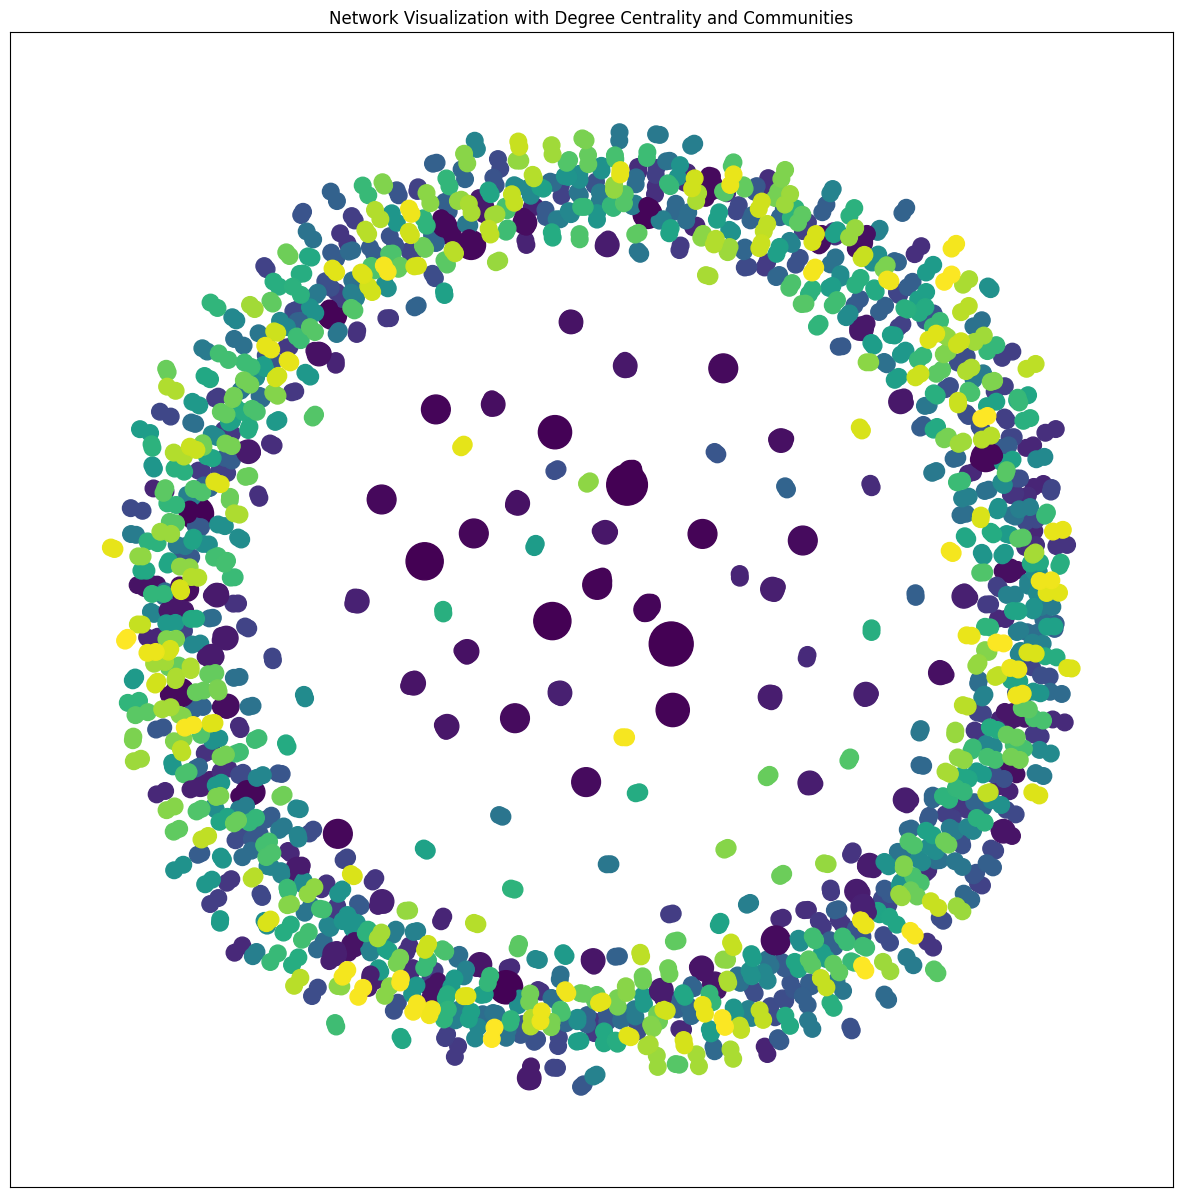

In [35]:
# Degree distribution on log-log scale
degree_centrality = cen.degree_centrality(G_sampled)
communities = community.greedy_modularity_communities(G_sampled)

max_centrality = max(degree_centrality.values())
node_size = [v / max_centrality * 1000 for v in degree_centrality.values()]

# Map each node to a community number
community_map = {}
for idx, community in enumerate(communities):
    for node in community:
        community_map[node] = idx

# Assign a color to each community
colors = [community_map[node] for node in G_sampled.nodes]

# Draw the network graph
plt.figure(figsize=(15, 15))
nx.draw_networkx(G_sampled, node_color=colors, node_size=node_size, with_labels=False)
plt.title("Network Visualization with Degree Centrality and Communities")
plt.show()

In [37]:
# Calculate the assortativity coefficient
assortativity_coefficient = nx.degree_assortativity_coefficient(G_sampled)
print(assortativity_coefficient)

-0.05544961737349178


### Node Attribute Analysis

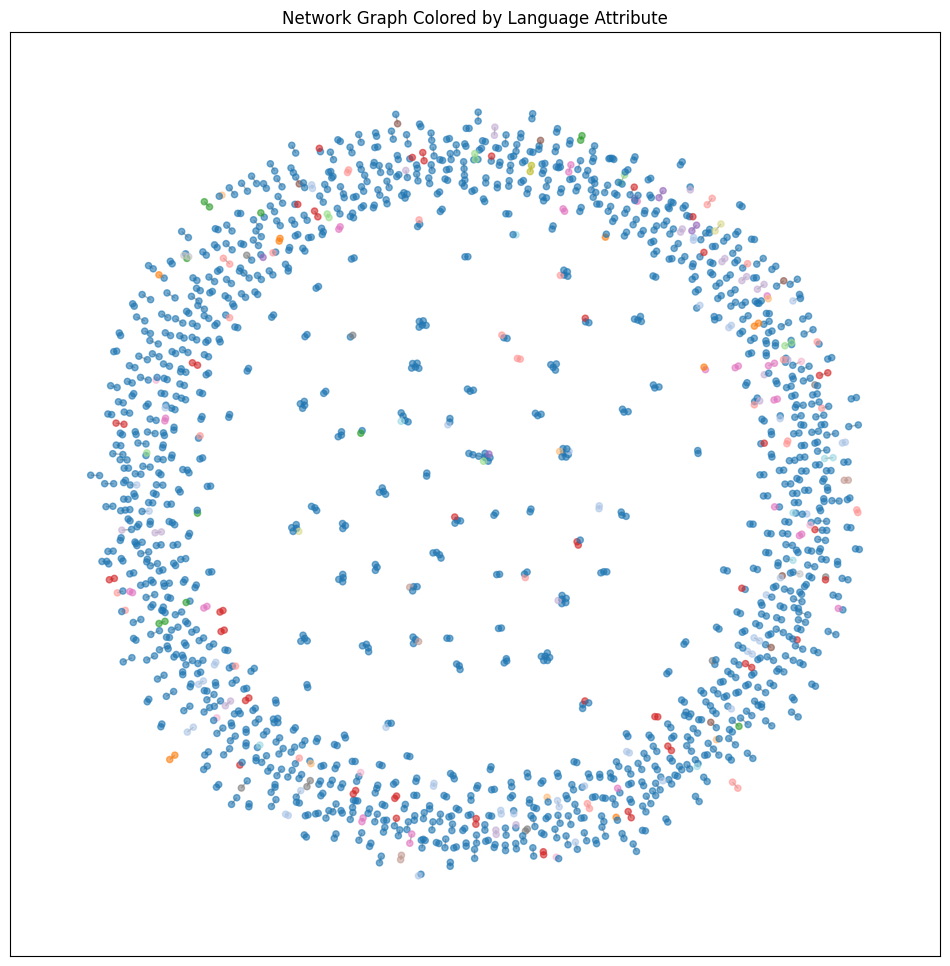

In [52]:
features_dict = df_features.set_index('numeric_id').to_dict('index')
nx.set_node_attributes(G_sampled, features_dict)

# First, create a mapping of language to color
unique_languages = pd.unique(df_features['language'])
color_map = {lang: plt.cm.tab20(i) for i, lang in enumerate(unique_languages)}

# Assign colors to each node based on their language attribute
node_colors = [color_map[data['language']] if 'language' in data else 'black' for node, data in G_sampled.nodes(data=True)]

# Draw the graph with node colors based on language
plt.figure(figsize=(12, 12))
nx.draw_networkx(G_sampled, node_color=node_colors, with_labels=False, node_size=20, edge_color='grey', alpha=0.6)
plt.title('Network Graph Colored by Language Attribute')
plt.show()

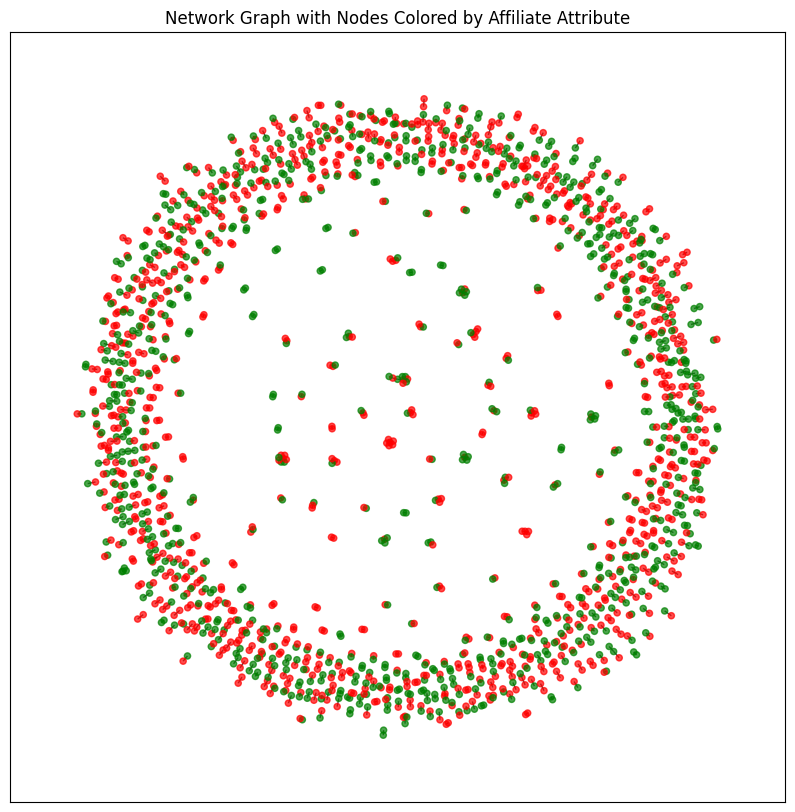

In [53]:
affiliate_dict = df_features.set_index('numeric_id')['affiliate'].to_dict()
nx.set_node_attributes(G_sampled, affiliate_dict, 'affiliate')

# Visualization: Color nodes by affiliate attribute
affiliate_colors = ['green' if data.get('affiliate', 0) == 1 else 'red' for node, data in G_sampled.nodes(data=True)]

# Draw the graph
plt.figure(figsize=(10, 10))
nx.draw_networkx(G_sampled, node_color=affiliate_colors, with_labels=False, node_size=20, alpha=0.7)
plt.title('Network Graph with Nodes Colored by Affiliate Attribute')
plt.show()

### Degree Sequence

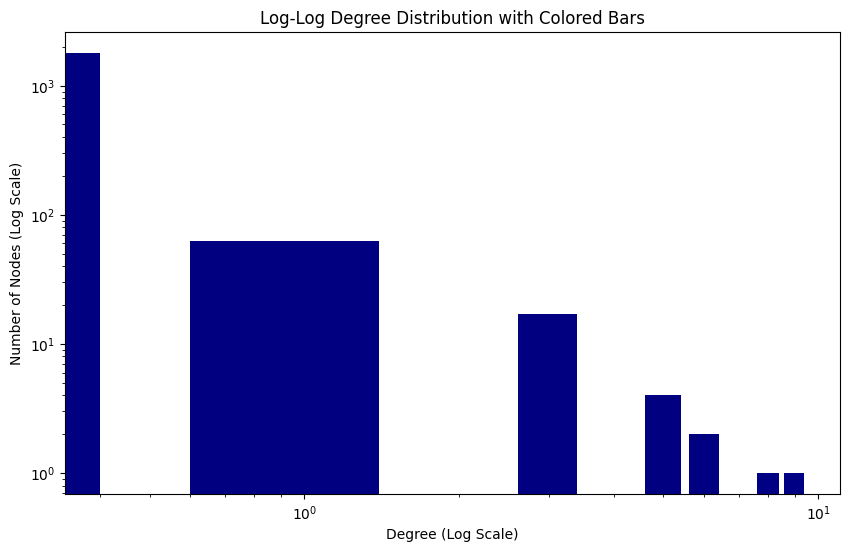

In [61]:
# Calculate the degree sequence
degree_sequence = sorted([d for n, d in G_sampled.degree()], reverse=True)

# Generate a list of colors, one for each bar in the histogram
colors = plt.cm.jet(np.linspace(0, 1, len(degree_sequence)))

# Calculate histogram data
hist, bins = np.histogram(degree_sequence, bins=10)

# Normalize the bins to log scale since we have log-log plot
logbins = np.logspace(np.log10(bins[0]), np.log10(bins[-1]), len(bins))

# Plot histogram with each bar having a unique color
plt.figure(figsize=(10, 6))
plt.bar(range(len(hist)), hist, color=colors, log=True)

# Set the x-axis to be log-scaled
plt.xscale('log')

# Set the axis labels and title
plt.xlabel('Degree (Log Scale)')
plt.ylabel('Number of Nodes (Log Scale)')
plt.title('Log-Log Degree Distribution with Colored Bars')

# Show the plot
plt.show()

## **Data Cleaning**

In [10]:
# Data Cleaning and Feature Engineering
# Convert 'created_at' and 'updated_at' to datetime
df_features['created_at'] = pd.to_datetime(df_features['created_at'])
df_features['updated_at'] = pd.to_datetime(df_features['updated_at'])

# Calculate 'account_age' in days
df_features['account_age'] = (df_features['updated_at'].max() - df_features['created_at']).dt.days

## **Feature Engineering**

<ipython-input-11-68c14ec9b5aa>:20: RuntimeWarning: divide by zero encountered in long_scalars
  if df[feature].max() / df[feature].min() > 100:


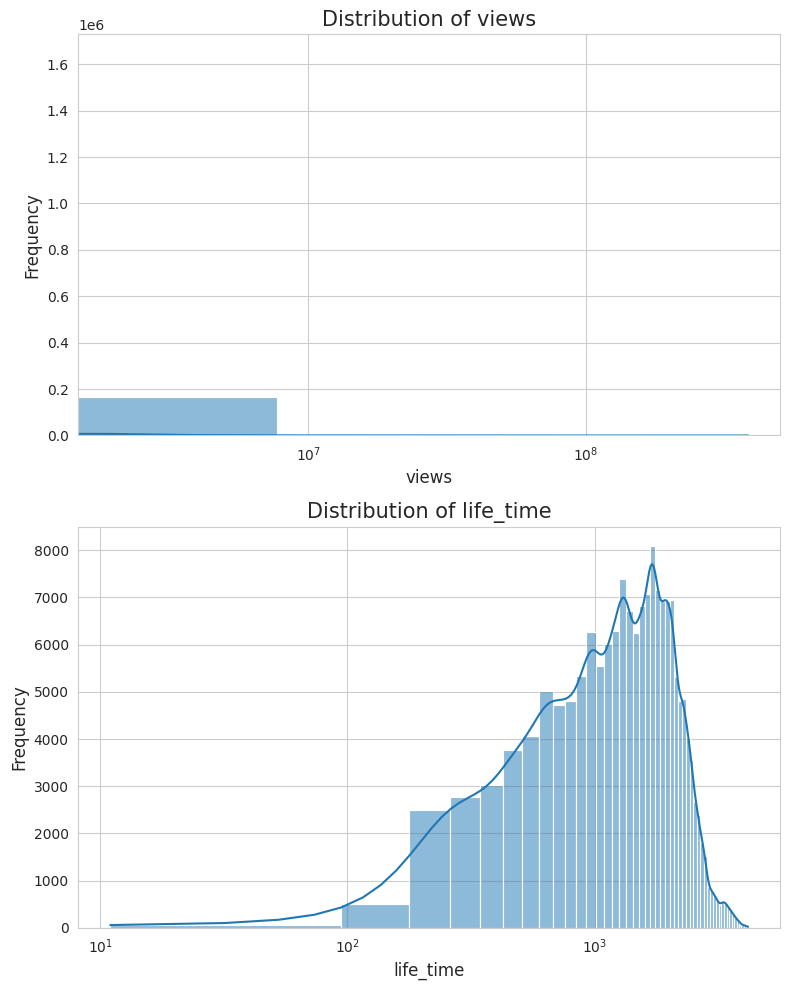

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Function to create distribution plots for numerical features
def plot_numerical_distributions(df, features):
    fig, axes = plt.subplots(nrows=len(features), ncols=1, figsize=(8, 5 * len(features)))

    if len(features) == 1:  # If there's only one feature, we don't have an array of axes
        axes = [axes]

    for ax, feature in zip(axes, features):
        sns.histplot(df[feature], bins=50, ax=ax, kde=True)
        ax.set_title(f'Distribution of {feature}', fontsize=15)
        ax.set_xlabel(feature, fontsize=12)
        ax.set_ylabel('Frequency', fontsize=12)
        # Log scale if the feature has a wide range
        if df[feature].max() / df[feature].min() > 100:
            ax.set_xscale('log')

    plt.tight_layout()
    return fig

# Plotting the distributions of 'views' and 'life_time'
plot_features = ['views', 'life_time']
fig = plot_numerical_distributions(df_features, plot_features)
plt.show()

In [12]:
# Visualizing and Transforming Numerical Features
# Views - Log Transformation
df_features['log_views'] = np.log(df_features['views'] + 1)

In [13]:
# Life Time - Box-Cox Transformation
df_features['life_time_shifted'] = df_features['life_time'] + 1  # Shift to handle zero values
df_features['life_time_box_cox'], fitted_lambda = stats.boxcox(df_features['life_time_shifted'])

<ipython-input-11-68c14ec9b5aa>:20: RuntimeWarning: divide by zero encountered in double_scalars
  if df[feature].max() / df[feature].min() > 100:


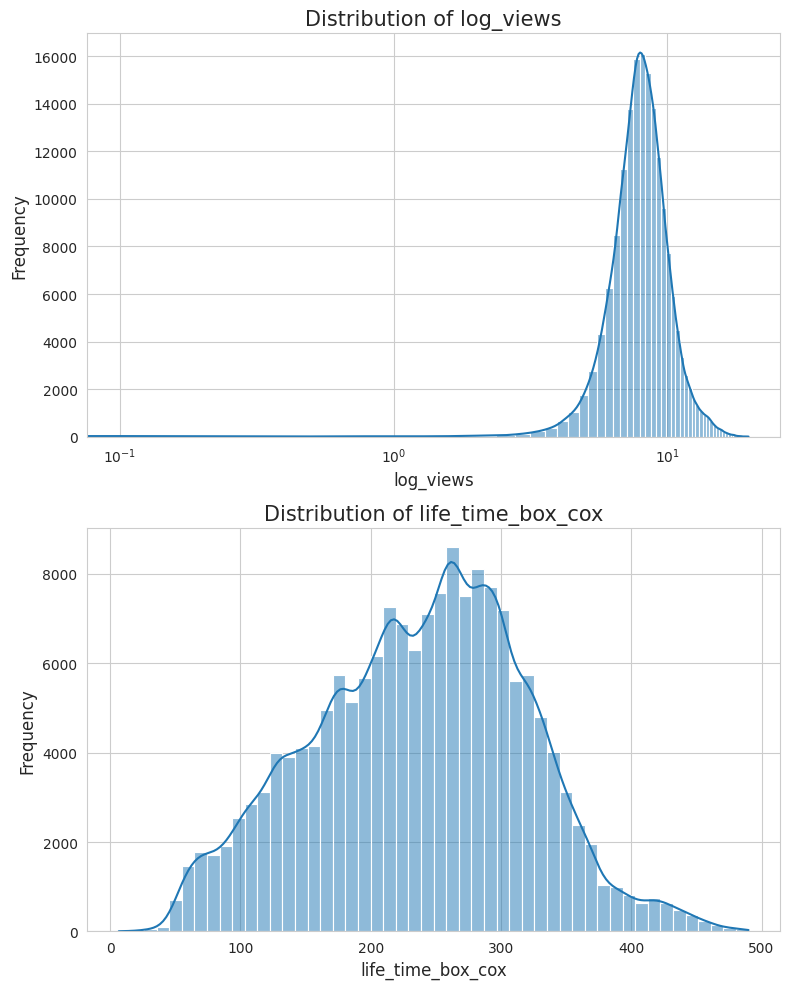

In [14]:
plot_features = ['log_views', 'life_time_box_cox']
fig = plot_numerical_distributions(df_features, plot_features)
plt.show()

In [15]:
# Analyzing and Encoding Categorical Features
# One-Hot Encoding 'language' feature
encoder = OneHotEncoder(sparse=False)
languages_encoded = encoder.fit_transform(df_features['language'].values.reshape(-1, 1))

# Convert to DataFrame
languages_encoded_df = pd.DataFrame(languages_encoded, columns=encoder.get_feature_names_out(['language']))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


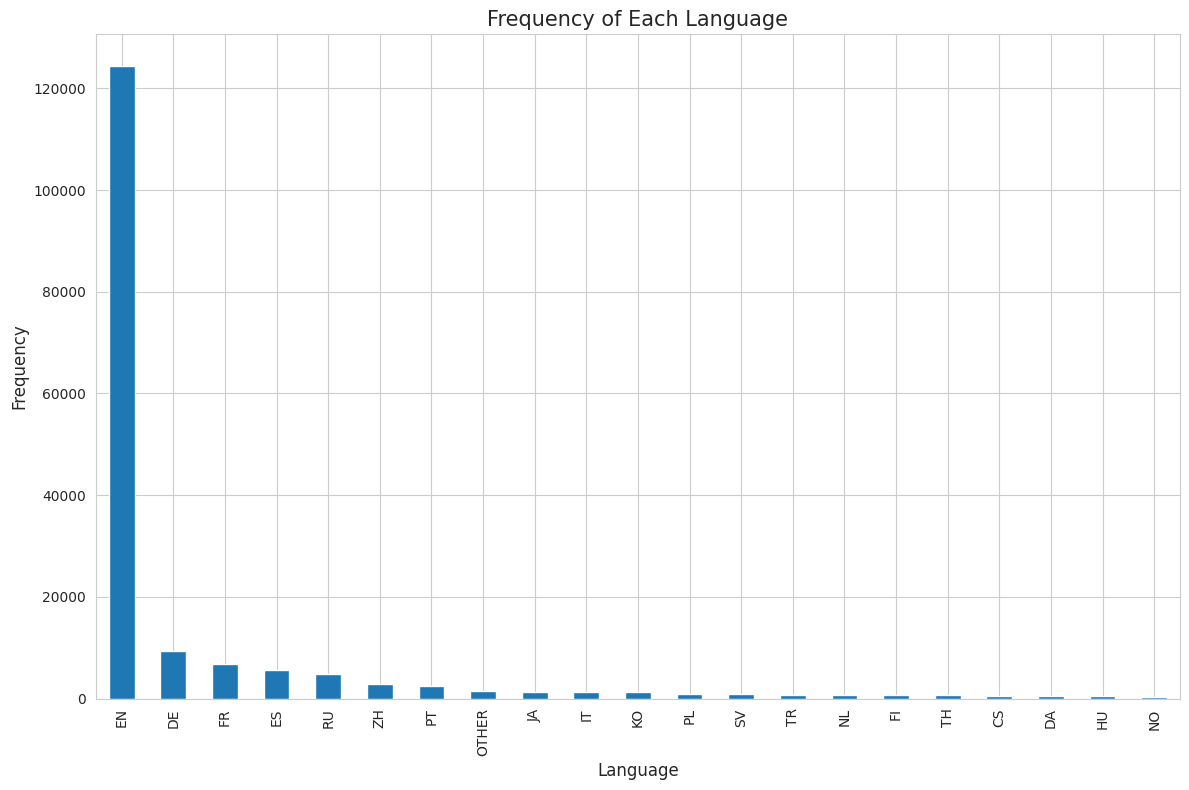

In [16]:
# Let's explore the 'language' categorical feature from the features dataframe

# Get the count of each language
language_counts = df_features['language'].value_counts()

# Visualize the counts of each language
fig, ax = plt.subplots(figsize=(12, 8))
language_counts.plot(kind='bar', ax=ax)
ax.set_title('Frequency of Each Language', fontsize=15)
ax.set_xlabel('Language', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.tick_params(axis='x', rotation=90)  # Rotate x-axis labels for better readability

plt.tight_layout()
plt.show()

In [17]:
# Binary Encoding 'language' feature
# This requires the category_encoders library which may not be available in the current environment
# Instead, we perform manual binary encoding
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(df_features['language'].values)
max_length = len(bin(max(integer_encoded))) - 2  # Subtract 2 for the '0b' prefix
binary_encoded = ['{0:b}'.format(x).zfill(max_length) for x in integer_encoded]
binary_encoded_df = pd.DataFrame([list(x) for x in binary_encoded], columns=[f'language_bin_{i}' for i in range(max_length)])
binary_encoded_df = binary_encoded_df.applymap(int)

binary_encoded_df.head()

,language_bin_0,language_bin_1,language_bin_2,language_bin_3,language_bin_4
0,0,0,0,1,1
1,0,0,0,1,1
2,0,0,0,1,1
3,0,0,0,1,1
4,0,0,0,1,1


## **Model Training**

In [18]:
features = df_features[["account_age", "log_views", "life_time_box_cox", "mature", "dead_account"]]
features = pd.concat([features, binary_encoded_df], axis=1)

In [19]:
target = df_features["affiliate"]

In [20]:
features

,account_age,log_views,life_time_box_cox,mature,dead_account,language_bin_0,language_bin_1,language_bin_2,language_bin_3,language_bin_4
0,970,8.972083,175.602630,1,0,0,0,0,1,1
1,2704,6.216606,361.409584,0,0,0,0,0,1,1
2,3150,12.854492,402.815266,1,0,0,0,0,1,1
3,1356,5.958425,221.188394,0,0,0,0,0,1,1
4,1786,7.818832,270.042441,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...
168109,815,8.510370,154.722854,0,0,0,0,0,1,1
168110,2081,8.325791,300.868867,1,0,0,0,0,1,1
168111,1800,8.173575,271.426903,0,0,0,0,0,1,1
168112,2136,13.702047,306.447780,1,0,0,0,0,1,1


In [21]:
features = features.to_numpy()

In [22]:
edge_index = torch.tensor([
    df_edges.numeric_id_1,
    df_edges.numeric_id_2
], dtype=torch.long)

In [23]:
#creating mask

TRAINING_NUM = int(features.shape[0] * 0.70)
TESTING_NUM = int(features.shape[0] * 0.20)
VALIDATION_NUM = int(features.shape[0] * 0.10)

training_mask = [1]*(TRAINING_NUM + (features.shape[0] - (TRAINING_NUM+TESTING_NUM+VALIDATION_NUM)))
testing_mask = [2]*TESTING_NUM
validation_mask = [3]*VALIDATION_NUM

overall_mask = np.array(training_mask +validation_mask+ testing_mask)

np.random.shuffle(overall_mask)

In [24]:
training_mask = (overall_mask == 1)
testing_mask = (overall_mask == 2)
validation_mask = (overall_mask == 3)

In [25]:
training_mask = torch.tensor(training_mask, dtype=torch.bool)
testing_mask = torch.tensor(testing_mask, dtype=torch.bool)
validation_mask = torch.tensor(validation_mask, dtype=torch.bool)

In [26]:
data = GData(
    x=torch.tensor(features, dtype=torch.float),
    edge_index=edge_index,
    y=torch.tensor(target.to_list()).reshape(-1, 1),
    test_mask=testing_mask,
    train_mask=training_mask,
    valid_mask=validation_mask
)

In [27]:
data

Data(x=[168114, 10], edge_index=[2, 6797557], y=[168114, 1], test_mask=[168114], train_mask=[168114], valid_mask=[168114])

In [30]:
data.num_features

10

In [ ]:
class TwitchAffilateNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.input =  GCNConv(data.num_features, 128)
        self.gcnn1 = GCNConv(128,64)
        self.gcnn2 = GCNConv(64,32)
        self.gcnn3 = GCNConv(32,16)
        self.gcnn4 = GCNConv(16, 8)
        self.linear1 = Linear(8, 4)
        self.linear2 = Linear(4, 2)
        self.linear3 = Linear(2, 1)
        self.batchNorm1 = BatchNorm(64)
        self.batchNorm2 = BatchNorm(32)
        self.batchNorm3 = BatchNorm(16)
        self.batchNorm4 = BatchNorm(8)

    def forward(self, data):
        x = self.input(data.x, data.edge_index)
        x = F.relu(x)
        x = self.gcnn1(x, data.edge_index)
        x = self.batchNorm1(x)
        x = F.relu(x)
        x = self.gcnn2(x, data.edge_index)
        x = self.batchNorm2(x)
        x = F.relu(x)
        x = self.gcnn3(x, data.edge_index)
        x = self.batchNorm3(x)
        x = F.relu(x)
        x = self.gcnn4(x, data.edge_index)
        x = self.batchNorm4(x)
        x = F.relu(x)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        return F.sigmoid(x)

In [ ]:
device = torch.device("cuda")

In [ ]:
# Assuming TwitchAffilateNN and data are defined and initialized
num_epochs = 1000
model = TwitchAffilateNN().to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, threshold=0.0001, verbose=True, min_lr=0.005)
#scheduler = CosineAnnealingLR(optimizer, T_max= num_epochs // 2, eta_min=0.0001)
#scheduler = OneCycleLR(optimizer, mode='min', factor=0.7, patience=10, threshold=0.0001, verbose=True, min_lr=0.001)

num_train_data = data.train_mask.sum()
num_valid_data = data.valid_mask.sum()
num_test_data = data.test_mask.sum()
best_val_acc = 0

tqdm_obj = tqdm(range(num_epochs))
history = {
    "loss" : [],
    "val_loss" : [],
    "test_loss": [],
    "acc" : [],
    "val_acc" : [],
    "test_acc": []
}

try:
    for epoch in tqdm_obj:
        model.train()
        optimizer.zero_grad()

        # Forward pass
        out = model(data)

        # Compute loss - ensure both output and labels are of float type
        loss = F.binary_cross_entropy(out[data.train_mask].float(), data.y[data.train_mask].float())

        # Backward pass and optimization
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        # Evaluation phase
        model.eval()
        with torch.no_grad():
            predictions = (out > 0.5)
            acc = ((predictions[data.train_mask] == data.y[data.train_mask]).sum() / num_train_data) * 100

            val_loss = F.binary_cross_entropy(out[data.valid_mask].float(), data.y[data.valid_mask].float())
            val_acc = ((predictions[data.valid_mask] == data.y[data.valid_mask]).sum() / num_valid_data) * 100

            test_loss = F.binary_cross_entropy(out[data.test_mask].float(), data.y[data.test_mask].float())
            test_acc = ((predictions[data.test_mask] == data.y[data.test_mask]).sum() / num_test_data) * 100

            scheduler.step(val_loss)

        # Model checkpointing
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')

        # Saving
        history["loss"].append(loss.cpu().detach().item())
        history["acc"].append(acc.cpu().detach().item())
        history["val_loss"].append(val_loss.cpu().detach().item())
        history["val_acc"].append(val_acc.cpu().detach().item())
        history["test_loss"].append(test_loss.cpu().detach().item())
        history["test_acc"].append(test_acc.cpu().detach().item())

        # Logging
        tqdm_obj.set_postfix_str(f"Train Acc: {acc:.4f}%, Val Acc: {val_acc:.4f}%, Test Acc: {test_acc:.4f}% \nLoss: {loss:.4f},  Val Loss: {val_loss:.4f}, Test Loss: {test_loss:.4f}")

except Exception as e:
    print(f"An error occurred during training: {e}")

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 00071: reducing learning rate of group 0 to 2.5000e-02.
Epoch 00199: reducing learning rate of group 0 to 1.2500e-02.
Epoch 00364: reducing learning rate of group 0 to 6.2500e-03.
Epoch 00375: reducing learning rate of group 0 to 5.0000e-03.


In [ ]:
graph_data = [
    go.Scatter(y=history["acc"], mode="lines" , name="Acc"),
    go.Scatter(y=history["val_acc"], mode="lines" , name="Val Acc"),
    go.Scatter(y=history["test_acc"], mode="lines" , name="Test Acc")
]

fig = go.Figure(data=graph_data)
fig.show()

In [ ]:
graph_data = [
    go.Scatter(y=history["loss"], mode="lines" , name="Loss"),
    go.Scatter(y=history["val_loss"], mode="lines" , name="Val Loss"),
    go.Scatter(y=history["test_loss"], mode="lines" , name="test Loss")
]

fig = go.Figure(data=graph_data)
fig.show()

## **Model Testing**

In [ ]:
# Load the best model saved during training
model.load_state_dict(torch.load('best_model.pth'))

# Set the model to evaluation mode
model.eval()

# Initialize variables to calculate accuracy
num_test_data = data.test_mask.sum()
correct = 0

# No gradient computation needed during testing
with torch.no_grad():
    # Forward pass
    out = model(data)

    # Convert predictions based on a threshold (0.5 for binary classification)
    predictions = (out > 0.5)

    # Compare predictions with the ground truth labels
    correct += (predictions[data.test_mask] == data.y[data.test_mask]).sum()

# Calculate the accuracy
test_acc = correct / num_test_data * 100

# Print the test accuracy
print(f'Test Accuracy: {test_acc:.2f}%')

Test Accuracy: 65.17%
